In [1]:
import os
import glob
import random

import torch
import torchvision
import numpy as np
import cv2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
import torch.nn.functional as F

from IPython.display import Image

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

device

'cuda'

## Датасет

Ссылка на датасет - https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza

Датасет состоит из изображений еды и изображений пиццы

Всего 2 класса.

Изображения изначально разных размеров, приведены изображения к одному размеру 100 на 100 пикселей

In [3]:
import matplotlib.pyplot as plt

In [4]:
DATA_PATH = r'D:\ProgrammingPython\neural_networks\pizza_not_pizza_100'
classes = {n: cls for n,cls in enumerate(os.listdir(DATA_PATH))}
classes_invert = {value:key for key, value in classes.items() }

class PizzaDataset(Dataset):
    
    def __init__(self, rootdir, transform) -> None:
        super().__init__()
        self.class_names = os.listdir(rootdir)
        self.class_idx = [i for i in range(len(self.class_names))]
        self.transform = transform
        self.images_pathes = []
        self.images_clas_names = []

        for cls_name in self.class_names:
            sub_root = os.path.join(rootdir, cls_name)
            self.images_pathes.extend(glob.glob(os.path.join(sub_root, '*.jpg')))
            self.images_clas_names.append(cls_name)

        random.shuffle(self.images_pathes)
            
    def __len__(self):
        return len(self.images_pathes)
    
    def __getitem__(self, index) -> tuple:

        img_path = self.images_pathes[index]
        image = cv2.imread(img_path)
        img_folder_pth = os.path.split(img_path)[0]
        cls_name = os.path.split(img_folder_pth)[-1]
        label = self.class_names.index(cls_name)
        
        if self.transform:
            image = self.transform(image)

        return (image, label)

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize(mean = 0.5, std = 0.5)
    ]
)

In [6]:
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

Оригинальный датасет не разделен на тренировочную и тестовую выборки, поэтому разделим датасет в соотношении 80 на 20

In [7]:
TEST_SIZE = 0.25
BATCH_SIZE = 32
SEED = 52

In [8]:
dataset = PizzaDataset(DATA_PATH, transform)

In [9]:
generator = torch.Generator().manual_seed(SEED)

train_dataset, test_dataset = random_split(dataset, [1-TEST_SIZE, TEST_SIZE], generator=generator)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [11]:
for x,y in train_loader:
    print(x.shape)
    print(y)
    break


torch.Size([32, 3, 100, 100])
tensor([1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 0, 0, 0])


## Модель

In [12]:
# выход с последнего слоя
print(f"Кол-во классов: {len(classes.values())}")

Кол-во классов: 2


Напишем полносвязную нейронную сеть классификатор

In [13]:
class PizzaClassificator(nn.Module):
    def __init__(self):
        super(PizzaClassificator, self).__init__()
        self.conv_1 = nn.Conv2d(3, 8, (3,3), 1)
        self.avPoll_1 = nn.AvgPool2d((2,2), 2)
        self.conv_2 = nn.Conv2d(8, 16, (3,3), 1)
        self.conv_3 = nn.Conv2d(16, 16, (3,3), 1)
        self.conv_4 = nn.Conv2d(16, 32, (3,3), 1)
        self.avPoll_2 = nn.AvgPool2d((2,2), 2)
        self.conv_5 = nn.Conv2d(32, 64, (3,3), 1)
        self.avPoll_3 = nn.AvgPool2d((2,2), 2)
        self.linear_1 = nn.Linear(64 * 9 * 9, 512)
        self.linear_2 = nn.Linear(512, 2)


    def forward(self, x):
        x = self.conv_1(x)
        x = F.tanh(x)
        x = self.avPoll_1(x)
        x = F.tanh(x)

        x = self.conv_2(x)
        x = F.tanh(x)
        x = self.conv_3(x)
        x = F.tanh(x)
        x = self.conv_4(x)
        x = F.tanh(x)
        x = self.avPoll_2(x)
        x = F.tanh(x)

        x = self.conv_5(x)
        x = F.tanh(x)
        x = self.avPoll_3(x)
        x = F.tanh(x)

        x = torch.flatten(x, start_dim=1)

        x = self.linear_1(x)
        x = F.tanh(x)
        x = self.linear_2(x)
        
        return x

In [14]:
model = PizzaClassificator()
model.to(device)
loss_function = torch.nn.CrossEntropyLoss()

optimizator = torch.optim.Adam(model.parameters(), lr=0.0001,)

In [15]:
def val(model, test_loader):
    model.eval()
    tp = 0
    total = 0

    for x,y in test_loader:
        y = y.to(device)
        pred = torch.argmax(model(x.to(device)), dim=1)
        tp += int((pred == y).sum().to('cpu'))
        total +=len(pred)
    
    return tp/total

def train(dataloader, model, loss_fn, op_fn, epoch):
    acc = 0
    for ep in range(epoch):
        for step, (x, y) in enumerate(dataloader):


            y_pred = model(x.to(device))
            loss = loss_fn(y_pred.to(device), y.to(device))

            op_fn.zero_grad()
            loss.backward()
            op_fn.step()

            if step%100 == 0:
                loss, current = loss.item(), (ep+1)*(step+1)*BATCH_SIZE
                print(f"loss = {loss}, samples = {current}")

        acc = val(model, test_loader)
        print('accuracy =', acc)

    return acc


In [16]:
accuracy = train(train_loader, model, loss_function, optimizator, 5)

loss = 0.6923006772994995, samples = 32


d:\ProgrammingPython\neural_networks\.conda\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


accuracy = 0.5987780040733197
loss = 0.6486058235168457, samples = 64
accuracy = 0.6537678207739308
loss = 0.6378130912780762, samples = 96
accuracy = 0.6578411405295316
loss = 0.639606773853302, samples = 128
accuracy = 0.6639511201629328
loss = 0.6345769166946411, samples = 160
accuracy = 0.6639511201629328


Сохраним модель, указав датасет, кол-во эпох и точность

In [17]:
accuracy = (accuracy*100)
output_str = f"convolutional_pizza_100_classificator_5_{accuracy:.2f}"
output_str = output_str.replace(".", "_")
output_str = output_str + '.pt'
print(output_str)

convolutional_pizza_100_classificator_5_66_40.pt


In [18]:
torch.save(model, output_str)

## Оценка модели

In [19]:
model.to('cpu')
model(x).size()

torch.Size([32, 2])

In [20]:
model.eval()

PizzaClassificator(
  (conv_1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (avPoll_1): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (conv_2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv_3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv_4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (avPoll_2): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (conv_5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (avPoll_3): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (linear_1): Linear(in_features=5184, out_features=512, bias=True)
  (linear_2): Linear(in_features=512, out_features=2, bias=True)
)

In [21]:
predicts = []
labels = []

for x,y in test_loader:
    y = y.to('cpu').numpy()
    pred = torch.argmax(model(x.to('cpu')), dim=1).to('cpu').numpy()
    predicts.append(pred)
    labels.append(y)

print(len(predicts))


16


Сравним истинные метки и ответы модели на первых десяти метках

In [27]:
print(f'labels  : {labels[:10]}')
print(f'predicts: {predicts[:10]}')

labels  : [0 1 0 0 1 1 0 0 0 0]
predicts: [0 0 0 0 1 1 0 0 0 0]


In [23]:
predicts = np.concatenate(predicts)
labels = np.concatenate(labels)

In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [29]:
print(f"Accuracy = {accuracy_score(labels, predicts)}",
    f"\nPrecision = {precision_score(labels, predicts, average=None, zero_division=0).mean()}",
    f"\nRecall = {recall_score(labels, predicts, average=None).mean()}")

Accuracy = 0.6639511201629328 
Precision = 0.6652991795077046 
Recall = 0.6644926814696803


In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, predicts, labels=tuple(classes.keys()))
cm.shape


(2, 2)

In [25]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Выведем матрицу ошибок

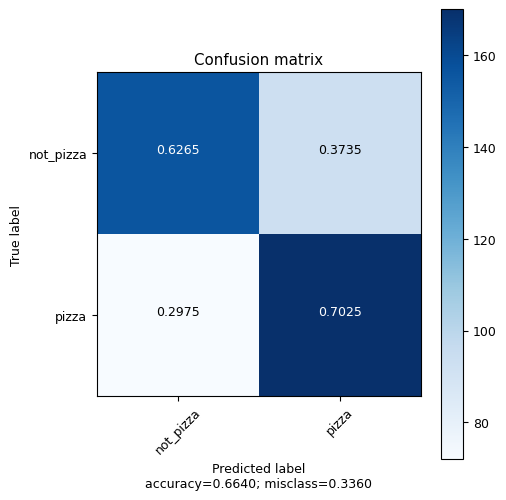

In [26]:
plt.figure(figsize=(5, 5))
plt.rcParams.update({'font.size': 9})
plot_confusion_matrix(cm, tuple(classes.values()))